In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
import numpy as np
from numpy.linalg import multi_dot, inv
import matplotlib.pyplot as plt
from scipy.sparse import diags


from scipy.io import loadmat
import numpy as np

import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, triu, vstack, diags, hstack
from scipy.sparse.linalg import inv
from absl import app, flags

In [64]:
# Check data
mat = sp.io.loadmat("dataset1.mat")

mat.keys()
# '__header__', '__version__', '__globals__',
# 'r', 'x_true', 't', 'v', 'l', 'r_var', 'v_var'

r = mat["r"]
x_true = mat["x_true"]
t = mat["t"]
v = mat["v"]
l = mat["l"]
r_var = mat["r_var"]
v_var = mat["v_var"]
# print(r.shape, x_true.shape, t.shape, v.shape, l.shape, r_var.shape, v_var.shape)

# (1,) -> (12709,)
l = np.broadcast_to(l, r.shape)
r_var = np.broadcast_to(r_var, r.shape)
v_var = np.broadcast_to(v_var, r.shape)

col_name = ["r", "x_true", "t", "v", "l", "r_var", "v_var"]
df = pd.DataFrame(np.hstack([r, x_true, t, v, l, r_var, v_var]), columns=col_name)
df.head(20)

,r,x_true,t,v,l,r_var,v_var
0,3.454506,0.984457,0.0,0.0,4.428479,0.000367,0.002261
1,3.456506,0.984434,0.1,0.0,4.428479,0.000367,0.002261
2,3.452506,0.984518,0.2,0.0,4.428479,0.000367,0.002261
3,3.454506,0.984452,0.3,0.0,4.428479,0.000367,0.002261
4,3.451506,0.984406,0.4,0.0,4.428479,0.000367,0.002261
5,3.456506,0.984454,0.5,0.0,4.428479,0.000367,0.002261
6,3.452506,0.984420,0.6,0.0,4.428479,0.000367,0.002261
7,3.452506,0.984401,0.7,0.0,4.428479,0.000367,0.002261
8,3.452506,0.984443,0.8,0.0,4.428479,0.000367,0.002261
9,3.450506,0.984389,0.9,0.0,4.428479,0.000367,0.002261


In [65]:
# load data
mat = sp.io.loadmat("dataset1.mat")
r = mat["r"].reshape(-1)
x_true = mat["x_true"].reshape(-1)
t = mat["t"].reshape(-1)
v = mat["v"].reshape(-1)
l = mat["l"].reshape(-1)
r_var = mat["r_var"].reshape(-1)
v_var = mat["v_var"].reshape(-1)

K = x_true.shape[0]  # 12709
T = 0.1

delta = 1000  # sub-sampling rate
k = (K - 1) // delta  # number of sub-samples

# x_0 = x_true[0]  # initial value
# u_0 = x_0
# y_0 = x_0

# make z
## make u
u = np.array([T * v[i * delta : (i + 1) * delta].sum() for i in range(0, k)]).reshape(-1, 1)
# u = np.insert(u, 0, u_0).reshape(-1, 1)

## make y
y = np.array([l[0] - r[(i + 1) * delta] for i in range(0, k)]).reshape(-1, 1)
# y = np.insert(y, 0, y_0).reshape(-1, 1)

## make z
z = np.vstack((u, y))


# make H
## make A_inv
A_inv = np.eye(k)
for row in range(1, A_inv.shape[0]):
    A_inv[row, row - 1] = -1

## make C
C = np.eye(k)

## make H
H = np.vstack([A_inv, C])


# make W
## make Q, R
Q = np.eye(k ) * v_var[0]
R = np.eye(k) * r_var[0]

## make W
W = np.block([[Q, np.zeros((k, k))], [np.zeros((k, k)), R]])
W_inv = np.linalg.inv(W)

# solution
## by formula

### dense way
# x = np.linalg.inv(H.T @ W_inv @ H) @ H.T @ W_inv @ z

### sparse way
H_sparse = sp.sparse.csr_matrix(H)
W_inv_sparse = sp.sparse.csr_matrix(W_inv)
P_check_sparse = sp.sparse.linalg.inv(H_sparse.T * W_inv_sparse * H_sparse)

x = P_check_sparse * H_sparse.T * W_inv_sparse * z



## RTS smoother
# TODO

x = x.reshape(-1)
x_true_sub = x_true[delta:K:delta]
error = x_true_sub - x

sigma = np.sqrt(P_check_sparse.diagonal())

t = [(i + 1) * delta * T for i in range(0, k)]

In [3]:
from scipy.sparse.linalg import inv as spinv
from scipy.sparse import csr_matrix, triu, vstack,diags
R = diags([3] * 5, format='csr')
R_inv = spinv(diags([3] * 5, format='csr'))
print(R)
print(R_inv)

  (0, 0)	3.0
  (1, 1)	3.0
  (2, 2)	3.0
  (3, 3)	3.0
  (4, 4)	3.0
  (0, 0)	0.3333333333333333
  (1, 1)	0.3333333333333333
  (2, 2)	0.3333333333333333
  (3, 3)	0.3333333333333333
  (4, 4)	0.3333333333333333


/home/hanxiongli/ser/ser/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/hanxiongli/ser/ser/lib/python3.8/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


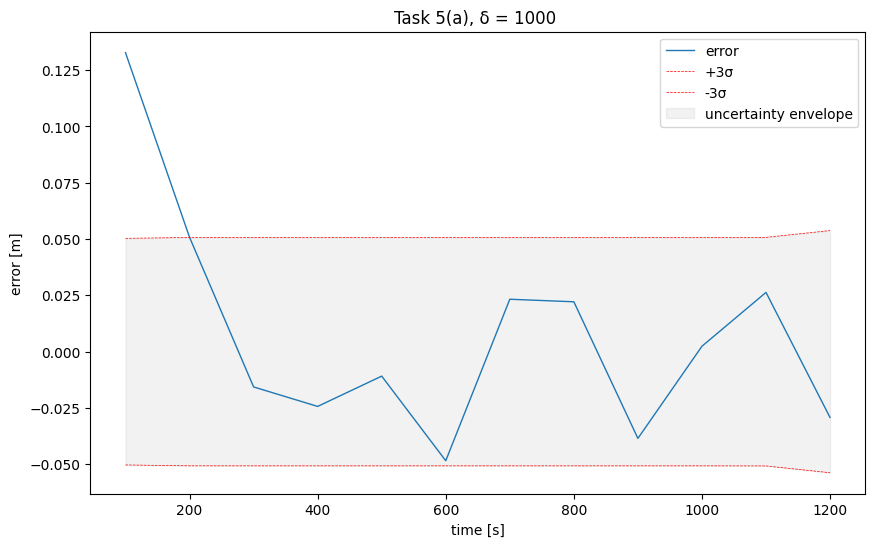

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title("Task 5(a), δ = {} ".format(delta))
ax.set_xlabel("time [s]")
ax.set_ylabel("error [m]")
ax.plot(t, error, linewidth=1, label="error")
ax.plot(t, 3 * sigma, color="red", linewidth=0.5, linestyle="--", label="+3σ")
ax.plot(t, -3 * sigma, color="red", linewidth=0.5, linestyle="--", label="-3σ")
ax.fill_between(
    t,
    3 * sigma,
    -3 * sigma,
    color="gray",
    alpha=0.1,
    label="uncertainty envelope",
)
ax.legend()

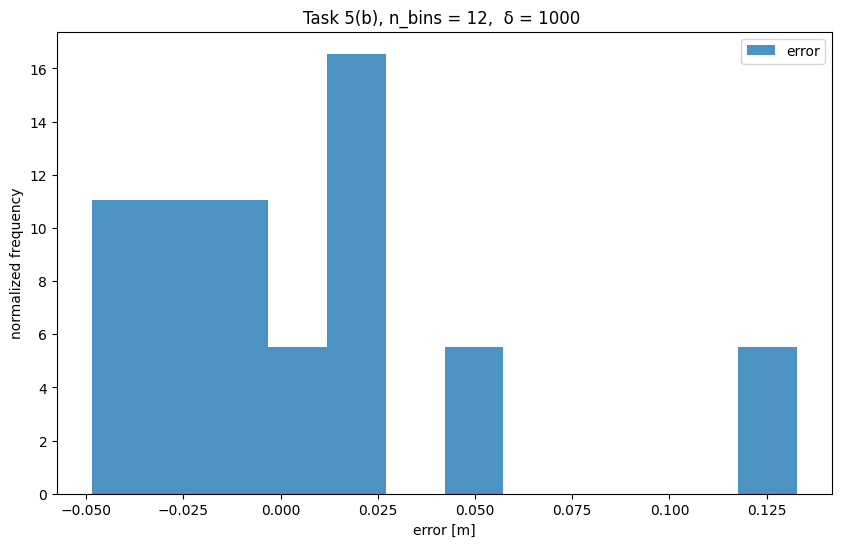

In [80]:
# histogram
n_bins = 12
# error_space = error.max() - error.min()
# interval = error_space / n_bins

# hist = np.zeros(n_bins)
# for val in error:
#     idx = int(abs(val - error.min()) / (interval + 1e-10))
#     hist[idx] += 1
# hist_norm = hist / hist.sum()

# histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_title("Task 5(b), n_bins = {},  δ = {} ".format(n_bins, delta))
ax.set_xlabel("error [m]")
ax.set_ylabel("normalized frequency")
ax.hist(error, bins=n_bins, density=True, alpha=0.8, label="error")
ax.legend()

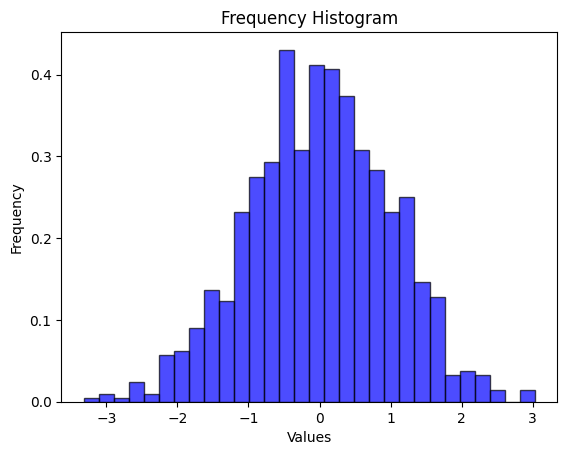

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# 创建示例数据（随机生成）
data = np.random.randn(1000)  # 生成1000个服从标准正态分布的随机数

# 绘制频率直方图
plt.hist(data, bins=30, alpha=0.7, color='blue', edgecolor='black',density=True)

# 设置图表标题和坐标轴标签
plt.title('Frequency Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')

# 显示图表
plt.show()


In [26]:
delta = 1000
T = 0.1
mat = loadmat("dataset1.mat")
num_states = len(mat["r"])
num_samples = num_states//delta
t = np.array(mat["t"][delta::delta])
# H <- [A_inv, C]T
A_inv = triu(np.ones((num_samples, num_samples))).tocsr()
# A_inv = inv(np.tril(np.ones((num_samples, num_samples))))
C = csr_matrix(np.eye(num_samples))
H = vstack([A_inv, C])
# H = np.concatenate((A_inv,C),axis = 0)
# H_t = csr_matrix(np.transpose(H))
# H_t = np.transpose(H)

# z <- [v, y]T
r = np.array(mat["r"][delta::delta])
l = np.array(mat["l"])
y = l-r
u = mat["v"]
v = np.zeros((num_samples,1))
for i in range(delta, num_states, delta):
    v[int(i/delta-1)] = T*np.sum(u[i-delta:i])
z = np.vstack((v,y))

# W <-[[Q,0],[0, R]]
r_var = mat["r_var"][0,0]
R_inv = diags([1/r_var] * num_samples, format='csr')
# R_inv = inv(np.diag([r_var]*num_samples))
v_var = mat["v_var"][0,0]
Q_inv = diags([1/v_var] * num_samples, format='csr')
# Q_inv = inv(np.diag([v_var]*num_samples))
zero_matrix = csr_matrix((num_samples, num_samples))
W_inv = vstack([hstack([Q_inv, zero_matrix]), hstack([zero_matrix, R_inv])])


In [3]:

delta = 3000
T = 0.1
mat = loadmat("dataset1.mat")
num_states = len(mat["r"])
num_samples = num_states//delta
t = np.array(mat["t"][delta::delta])
# H <- [A_inv, C]T
A_inv = np.linalg.inv(np.tril(np.ones((num_samples, num_samples))))
C = np.eye(num_samples)
H = np.concatenate((A_inv,C),axis = 0)
H_t = np.transpose(H)

# z <- [v, y]T
r = np.array(mat["r"][delta::delta])
l = np.array(mat["l"])
y = l-r
u = mat["v"]
v = np.zeros((num_samples,1))
for i in range(delta, num_states, delta):
    v[int(i/delta-1)] = T*np.sum(u[i-delta:i])
z = np.vstack((v,y))

# W <-[[Q,0],[0, R]]
r_var = mat["r_var"][0,0]
R_inv = np.linalg.inv(np.diag([r_var]*num_samples))
v_var = mat["v_var"][0,0]
Q_inv = np.linalg.inv(np.diag([v_var]*num_samples))
W_inv = np.block([[Q_inv, np.zeros((num_samples, num_samples))],
                        [np.zeros((num_samples, num_samples)), R_inv]])

# sigma
P_hat_invert = multi_dot([H_t,W_inv,H])
P_hat = np.linalg.inv(multi_dot([H_t,W_inv,H]))
sigma = np.sqrt(np.diag(P_hat))

# error
x_estimate = multi_dot([P_hat,H_t,W_inv,z])
x_true = np.array(mat["x_true"][delta::delta])
error = x_true-x_estimate

In [6]:
A_inv

array([[ 1.,  0.,  0.,  0.],
       [-1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  0.],
       [ 0.,  0., -1.,  1.]])